In [1]:
import pandas
from gym import Env
import numpy as np
import gym.spaces as spaces
import numpy as np
from stable_baselines3 import PPO
import random
from tqdm import trange
import statistics

/Users/charlie/.conda/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Implementation of the Env, 2048. It has been optimized for betterruntime but it still takes 3 hours to train. Ideally, It would train for more timesteps but I am limited to m1. 

In [2]:
class env2048(Env):
    def __init__(self, size = 4):
        self.t = 0
        self.size = size
        self.action_space=spaces.Box(0, 1.0, (4,))
        self.observation_space = spaces.Box(low=0, high=20, shape=(size, size), dtype=np.float32)
        self.state = np.zeros(shape=(size, size), dtype=np.float32)
        self.randomBlock()
    def filled(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.state[i][j] == 0:
                    return False
        return True
    def randomBlock(self):
        x = np.random.randint(0, self.size)
        y = np.random.randint(0, self.size)
        while self.state[x][y] != 0:
            x = np.random.randint(0, self.size)
            y = np.random.randint(0, self.size)
        self.state[x][y] = random.randint(1, 2)
    def left(self):
        change = False
        for i in range(self.size):
            prev = 0
            for j in range(1, self.size):
                if self.state[i][j] == 0:
                    continue
                if self.state[i][prev] == self.state[i][j]:
                    self.state[i][prev] += 1
                    self.state[i][j] = 0
                    change = True
                    continue
                if self.state[i][prev] == 0:
                    self.state[i][prev], self.state[i][j] = self.state[i][j], self.state[i][prev]
                    change = True
                    continue
                if self.state[i][prev] != self.state[i][j]:
                    self.state[i][prev + 1], self.state[i][j] = self.state[i][j], self.state[i][prev + 1]
                    prev += 1
                    change = True
        return change
    def right(self):
        change = False
        for i in range(self.size):
            prev = self.size - 1
            for j in range(self.size - 2, -1, -1):
                if self.state[i][j] == 0:
                    continue
                if self.state[i][prev] == self.state[i][j]:
                    self.state[i][prev] += 1
                    self.state[i][j] = 0
                    change = True
                    continue
                if self.state[i][prev] == 0:
                    self.state[i][prev], self.state[i][j] = self.state[i][j], self.state[i][prev]
                    change = True
                    continue
                if self.state[i][prev] != self.state[i][j]:
                    self.state[i][prev - 1], self.state[i][j] = self.state[i][j], self.state[i][prev - 1]
                    prev -= 1
                    change = True
        return change
    def up(self):
        change = False
        for i in range(self.size):
            prev = 0
            for j in range(1, self.size):
                if self.state[j][i] == 0:
                    continue
                if self.state[prev][i] == self.state[j][i]:
                    self.state[prev][i] += 1
                    self.state[j][i] = 0
                    change = True
                    continue
                if self.state[prev][i] == 0:
                    self.state[prev][i], self.state[j][i] = self.state[j][i], self.state[prev][i]
                    change = True
                    continue
                if self.state[prev][i] != self.state[j][i]:
                    self.state[prev + 1][i], self.state[j][i] = self.state[j][i], self.state[prev + 1][i]
                    prev += 1
                    change = True
        return change
    def down(self):
        change = False
        for i in range(self.size):
            prev = self.size - 1
            for j in range(self.size - 2, -1, -1):
                if self.state[j][i] == 0:
                    continue
                if self.state[prev][i] == self.state[j][i]:
                    self.state[prev][i] += 1
                    self.state[j][i] = 0
                    change = True
                    continue
                if self.state[prev][i] == 0:
                    self.state[prev][i], self.state[j][i] = self.state[j][i], self.state[prev][i]
                    change = True
                    continue
                if self.state[prev][i] != self.state[j][i]:
                    self.state[prev - 1][i], self.state[j][i] = self.state[j][i], self.state[prev - 1][i]
                    prev -= 1
                    change = True
        return change
    def move(self, action):
        prev = np.copy(self.state)
        if action == 0:
            self.left()
        if action == 1:
            self.right()
        if action == 2:
            self.up()
        if action == 3:
            self.down()
        return np.array_equal(prev, self.state)
    def reward(self):
        reward = 0
        for i in range(self.size):
            for j in range(self.size):
                reward += self.state[i][j]
        return reward
    def done(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.state[i][j] == 0:
                    return False
                if j + 1 < self.size:
                    if self.state[i][j] == self.state[i][j + 1] and j + 1 < self.size:
                        return False
                if i + 1 < self.size:
                    if self.state[i][j] == self.state[i + 1][j] and i + 1 < self.size:
                        return False
        return True
    def step(self, inputs):
        self.s += 1
        action = np.argmax(inputs)
        inputs[action] = -1
        while (self.move(action) == True):
            action = np.argmax(inputs)
            inputs[action] = -1
        self.randomBlock()
        info = {}
        done = self.done()
        reward = 1
        if done:
            reward = -1
        return self.state, reward, done, info
    def render(self):
        print(self.state)
    def close(self):
        pass
    def reset(self):
        self.s = 0
        self.state = np.zeros(shape=(self.size, self.size), dtype=np.float32)
        self.randomBlock()
        return self.state


Calling the env and creating the model. Model is PPO, and is explained in my notebook.

In [3]:
env = env2048()
model = PPO("MlpPolicy", env, verbose=1, device='mps')

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Taking the performance before the model gets trained. It takes 1000 sampels so it should not be biased or affected by randomness

In [4]:
before = []
for i in trange(1000):
    r = 0
    done = False
    obs = env.reset()
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        r += 1
    before.append(r)

100%|██████████| 1000/1000 [03:02<00:00,  5.49it/s]


The performance of the human heuristics. This represents how a human would code a AI.

In [5]:
control = []
for i in trange(1000):
    r = 0
    done = False
    obs = env.reset()
    while not done:
        obs, reward, done, info = env.step(np.array([4, 2, 1, 3]))
        r += 1
    control.append(r)

100%|██████████| 1000/1000 [00:08<00:00, 118.61it/s]


Training the model...

In [6]:
model.learn(total_timesteps=500000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81       |
|    ep_rew_mean     | 79       |
| time/              |          |
|    fps             | 238      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 81.1        |
|    ep_rew_mean          | 79.1        |
| time/                   |             |
|    fps                  | 174         |
|    iterations           | 2           |
|    time_elapsed         | 23          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013615657 |
|    clip_fraction        | 0.0819      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.67       |
|    explained_variance   | -0.0277     |
|    learning_rate        | 0.

Taking the performance after the training

In [7]:
after = []
for i in trange(1000):
    r = 0
    done = False
    obs = env.reset()
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        r += 1
    after.append(r)

100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]


Plotting the results

before: 91.038 after: 98.427 control: 116.268


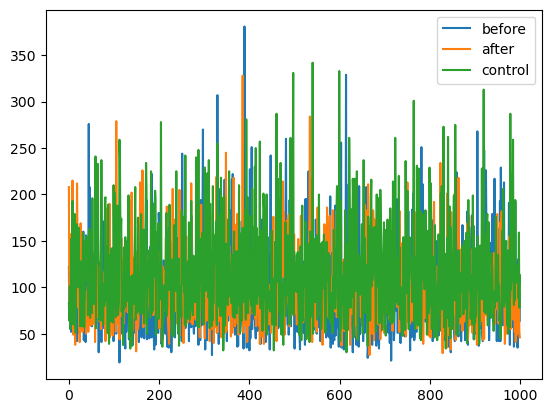

In [8]:
import matplotlib.pyplot as plt
plt.plot(before, label='before')
plt.plot(after, label='after')
plt.plot(control, label='control')
plt.legend()
print(f'before: {statistics.mean(before)} after: {statistics.mean(after)} control: {statistics.mean(control)}')

**Conclusion**

PPO has not performed as well as I hoped. This may be because I did not fine tune the parameters of the network due to my inexperience in stablebaseline3 or too few training steps. The model does show signifcant improvement although the heruistics outperformed by quite a bit. PPO does work, but not well.